In [1]:
# git config --global credential.helper store

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import itertools
from collections import Counter
import ssl
import time
import string
import unicodedata
%matplotlib inline

from urllib.request import Request, urlopen
from threading import Thread
from bs4 import BeautifulSoup

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor,
                            GradientBoostingClassifier, GradientBoostingRegressor)

import nltk
nltk.download(["stopwords", "punkt", "averaged_perceptron_tagger", "maxent_treebank_pos_tagger"])
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk import RegexpParser
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from clean_dfs import clean_features, clean_weeks, clean_lyrics
from web_scraping import parse_page, store_lyrics, filter_profanity
from nlp_pipeline import lyrics_tokenize, get_tfidf_matrix
from genre_helper_functions import get_bucket, contains_genre_type, create_genre_column
import make_plots as plots
import modeling_functions as model

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping taggers/maxent_treebank_pos_tagger.zip.

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package averaged_percept

In [2]:
features = clean_features()
#weeks = clean_weeks()

In [3]:
'''joined = weeks.merge(features, on='SongID')
#joined.to_csv("data/joined.csv", index=False)

# Expand genres into individual components
featureGenres = features.explode('spotify_genre')
featureGenres = featureGenres[featureGenres['spotify_genre'] != '']

joinedGenres = joined.explode('spotify_genre')
joinedGenres = joinedGenres[joinedGenres['spotify_genre'] != '']

explicitness = joined[['Year', 'spotify_track_explicit']]
explicitness = explicitness.groupby(['Year']).mean().reset_index()

numericalMetrics = joined.columns.tolist()[11:23]
numericals = joined[['Year'] + numericalMetrics].groupby(['Year']).mean().reset_index()'''

'joined = weeks.merge(features, on=\'SongID\')\n#joined.to_csv("data/joined.csv", index=False)\n\n# Expand genres into individual components\nfeatureGenres = features.explode(\'spotify_genre\')\nfeatureGenres = featureGenres[featureGenres[\'spotify_genre\'] != \'\']\n\njoinedGenres = joined.explode(\'spotify_genre\')\njoinedGenres = joinedGenres[joinedGenres[\'spotify_genre\'] != \'\']\n\nexplicitness = joined[[\'Year\', \'spotify_track_explicit\']]\nexplicitness = explicitness.groupby([\'Year\']).mean().reset_index()\n\nnumericalMetrics = joined.columns.tolist()[11:23]\nnumericals = joined[[\'Year\'] + numericalMetrics].groupby([\'Year\']).mean().reset_index()'

In [4]:
'''# Normalize numerical features not between 0 and 1
featureGenresNorm = featureGenres.copy()
scaled = ["track_duration", "loudness", "tempo"]
for metric in scaled:
    mms = MinMaxScaler()
    featureGenresNorm[metric] = mms.fit_transform(featureGenresNorm['track_duration']. \
                                to_numpy().reshape(-1, 1))

# Create grouped tables
genres = featureGenres.groupby(['spotify_genre'])['SongID'].count().reset_index()
genresJoined = joinedGenres.groupby(['spotify_genre'])['SongID'].count().reset_index()
genresJoinedDecade = joinedGenres.groupby(['spotify_genre', 'Decade'])['SongID'].count(). \
                        reset_index().sort_values(by="Decade")
genreFeatures = featureGenresNorm.groupby(['spotify_genre'])[numericalMetrics].mean().reset_index()'''

'# Normalize numerical features not between 0 and 1\nfeatureGenresNorm = featureGenres.copy()\nscaled = ["track_duration", "loudness", "tempo"]\nfor metric in scaled:\n    mms = MinMaxScaler()\n    featureGenresNorm[metric] = mms.fit_transform(featureGenresNorm[\'track_duration\'].                                 to_numpy().reshape(-1, 1))\n\n# Create grouped tables\ngenres = featureGenres.groupby([\'spotify_genre\'])[\'SongID\'].count().reset_index()\ngenresJoined = joinedGenres.groupby([\'spotify_genre\'])[\'SongID\'].count().reset_index()\ngenresJoinedDecade = joinedGenres.groupby([\'spotify_genre\', \'Decade\'])[\'SongID\'].count().                         reset_index().sort_values(by="Decade")\ngenreFeatures = featureGenresNorm.groupby([\'spotify_genre\'])[numericalMetrics].mean().reset_index()'

In [5]:
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

In [6]:
'''# Web scrape lyrics
featureScrape = features.loc[[contains_genre_type(genre, ["pop", "rock", "metal"]) for genre \
                             in features['spotify_genre']]].reset_index(drop=True)
lyricsMap = {}
threads = []
temp = 0
start = time.time()
# Write scraped lyrics to hashmap, parallelize to save time (thread safe because no unique keys)
#for i in range(temp, temp+50):
for i in range(len(featureScrape)):
    t = Thread(target=store_lyrics, args=(featureScrape['Song'][i],
                featureScrape['Performer'][i], lyricsMap))
    threads.append(t)
    t.start()
for t in threads:
    t.join()
end = time.time()
print(end - start)
scrapedLyrics = pd.DataFrame(lyricsMap.items(), columns=["SongID", "Lyrics"])
scrapedLyrics.to_csv("data/scrapedLyrics.csv", index=False)

# Get list of all improperly formatted songs and save to file
problemSongs = []
for k, v in lyricsMap.items():
    if v[0][0] == "*":
        problemSongs.append([k] + v[2:5])
print(len(featureScrape), len(problemSongs))

with open("data/problemSongs.txt", "w") as file:
    for s in problemSongs:
        file.write("{}\n".format(s))'''

'# Web scrape lyrics\nfeatureScrape = features.loc[[contains_genre_type(genre, ["pop", "rock", "metal"]) for genre                              in features[\'spotify_genre\']]].reset_index(drop=True)\nlyricsMap = {}\nthreads = []\ntemp = 0\nstart = time.time()\n# Write scraped lyrics to hashmap, parallelize to save time (thread safe because no unique keys)\n#for i in range(temp, temp+50):\nfor i in range(len(featureScrape)):\n    t = Thread(target=store_lyrics, args=(featureScrape[\'Song\'][i],\n                featureScrape[\'Performer\'][i], lyricsMap))\n    threads.append(t)\n    t.start()\nfor t in threads:\n    t.join()\nend = time.time()\nprint(end - start)\nscrapedLyrics = pd.DataFrame(lyricsMap.items(), columns=["SongID", "Lyrics"])\nscrapedLyrics.to_csv("data/scrapedLyrics.csv", index=False)\n\n# Get list of all improperly formatted songs and save to file\nproblemSongs = []\nfor k, v in lyricsMap.items():\n    if v[0][0] == "*":\n        problemSongs.append([k] + v[2:5])\nprin

In [7]:
# Read csv of previously outputted scraped lyrics and reformat to match original
# allLyrics = clean_lyrics()

In [8]:
'''# NLP pipeline to create tokens from lyrics
allLyrics['Lyrics_tokenized'] = list(map(lyrics_tokenize, allLyrics['Lyrics']))
allLyrics.dropna(inplace=True)
allLyrics.to_csv("data/lyricsTokenized.csv", index=False)'''

'# NLP pipeline to create tokens from lyrics\nallLyrics[\'Lyrics_tokenized\'] = list(map(lyrics_tokenize, allLyrics[\'Lyrics\']))\nallLyrics.dropna(inplace=True)\nallLyrics.to_csv("data/lyricsTokenized.csv", index=False)'

In [9]:
###################

In [10]:
# Create corpus and make dataframe with TF-IDF matrix
allLyrics = pd.read_csv("data/lyricsTokenized.csv")
allLyrics.dropna(inplace=True)
corpus = allLyrics['Lyrics_tokenized']
tfidfLyrics = get_tfidf_matrix(corpus, 5000)
tfidfLyrics.insert(0, "SongID", allLyrics['SongID'])
tfidfLyrics.to_csv("data/tfidfMatrix.csv", index=False)

In [11]:
# Run models with only lyrics, not counting other features

In [12]:
# Join with valence column from features to get valence of each song
valenceOnly = pd.DataFrame({"SongID": features['SongID'], "spotify_genre": 
                            features['spotify_genre'], "valence": features['valence']})
lyricsAndValence = tfidfLyrics.merge(valenceOnly, on='SongID')
lyricsAndValence.set_index("SongID", inplace=True)
# Create new dataframe using classifier instead of regressor
lyricsAndValenceBin = lyricsAndValence.copy()
lyricsAndValenceBin['valence'] = (lyricsAndValenceBin['valence'] > 0.5).astype(int)

In [13]:
# Run classifier models for pop genre
lyricsAndValenceBinPop = lyricsAndValenceBin[[contains_genre_type(g, ["pop"]) \
                                for g in lyricsAndValenceBin['spotify_genre']]]
lyricsAndValenceBinPop.drop(["spotify_genre"], axis=1, inplace=True)
X = lyricsAndValenceBinPop[lyricsAndValenceBinPop.columns.difference(['valence'])]
y = lyricsAndValenceBinPop['valence']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [14]:
# Logistic regression model
logistic_regression_results = model.get_logistic_regression_results(X_train, \
                                        X_test, y_train, y_test)
print(logistic_regression_results)
# 0.5559, 0.3957, 0.3917

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.5558646267964766, 0.39567430025445294, 0.3916876574307305)


In [15]:
# Explore gradient boosting classifier hyperparameters
'''start = time.time()
model.plot_gradient_boost_class_hyperparameters(X_train, X_test, y_train, y_test, "pop")
end = time.time()
print(end-start)'''

'start = time.time()\nmodel.plot_gradient_boost_class_hyperparameters(X_train, X_test, y_train, y_test, "pop")\nend = time.time()\nprint(end-start)'

In [16]:
# Gradient boosting classifier model
gradient_boost_class_results = model.get_gradient_boost_class_results(0.1, 140, 3, \
                                        X_train, X_test, y_train, y_test)
print(gradient_boost_class_results)
# 0.6347, 0.0585, 0.4894

(0.6351414000927214, 0.11577608142493638, 0.4972677595628415)


In [17]:
# Run regressor models for pop genre
lyricsAndValencePop = lyricsAndValence[[contains_genre_type(g, ["pop"]) \
                            for g in lyricsAndValence['spotify_genre']]]
lyricsAndValencePop.drop(["spotify_genre"], axis=1, inplace=True)
X = lyricsAndValencePop[lyricsAndValencePop.columns.difference(['valence'])]
y = lyricsAndValencePop['valence']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [18]:
# Baseline RMSE is the standard deviation
print(lyricsAndValencePop['valence'].std())
# 0.2379

0.2379151415411867


In [19]:
'''# Grid search gradient boosting regressor hyperparameters and return model score and RMSE
gbr = model.grid_search_gradient_boost(X_train, X_test, y_train, y_test)
print(gbr.best_params_, np.sqrt(np.abs(gbr.best_score_)))
scoreValencePop = gbr.score(X_test, y_test)
y_pred = gbr.predict(X_test)
rmseValencePop = np.sqrt(mean_squared_error(y_test, y_pred))
print(scoreValencePop, rmseValencePop)
gradient_boost_class_results = model.get_gradient_boost_class_results(0.1, 140, 3, \
                                        X_train, X_test, y_train, y_test)
print(gradient_boost_class_results)'''

'# Grid search gradient boosting regressor hyperparameters and return model score and RMSE\ngbr = model.grid_search_gradient_boost(X_train, X_test, y_train, y_test)\nprint(gbr.best_params_, np.sqrt(np.abs(gbr.best_score_)))\nscoreValencePop = gbr.score(X_test, y_test)\ny_pred = gbr.predict(X_test)\nrmseValencePop = np.sqrt(mean_squared_error(y_test, y_pred))\nprint(scoreValencePop, rmseValencePop)\ngradient_boost_class_results = model.get_gradient_boost_class_results(0.1, 140, 3,                                         X_train, X_test, y_train, y_test)\nprint(gradient_boost_class_results)'

In [20]:
# Explore gradient boosting regressor hyperparameters
'''start = time.time()
model.plot_gradient_boost_reg_hyperparameters(X_train, X_test, y_train, y_test, "pop")
end = time.time()
print(end-start)'''

'start = time.time()\nmodel.plot_gradient_boost_reg_hyperparameters(X_train, X_test, y_train, y_test, "pop")\nend = time.time()\nprint(end-start)'

In [21]:
# Gradient boosting regressor model
gradient_boost_reg_results, feature_importances = model.get_gradient_boost_reg_results( \
                            0.05, 120, 3, X_train, X_test, y_train, y_test)
print(gradient_boost_reg_results)
# 0.006539, 0.2334

(0.0021545948259500403, 0.23391193871176555)


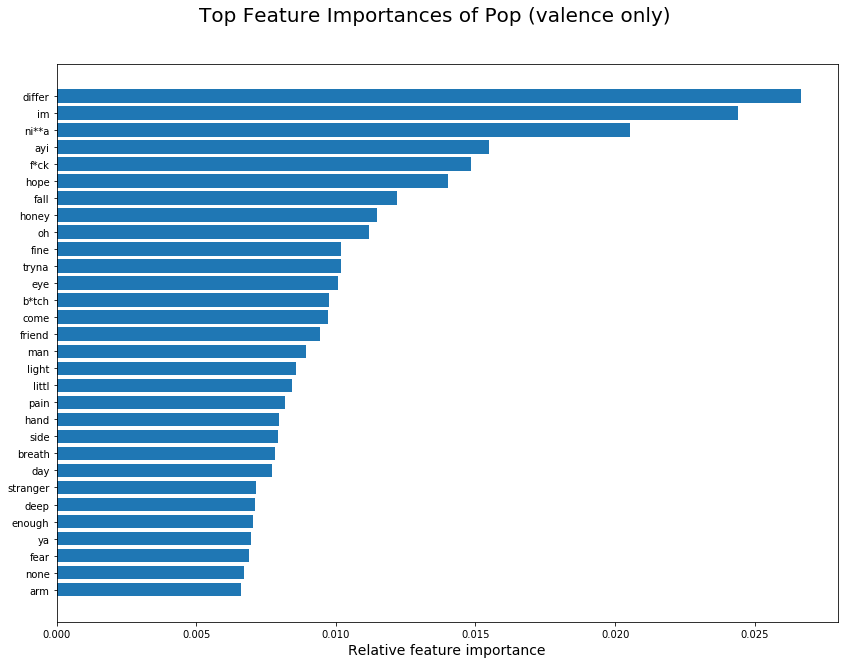

In [22]:
# Plot feature importances
fig, ax = plt.subplots(figsize=(12, 8))
filteredWords = np.array(filter_profanity(lyricsAndValencePop.columns.difference(['valence'])))
plots.make_feature_importance_plot(feature_importances, filteredWords, 30, ax)
fig.suptitle("Top Feature Importances of Pop (valence only)", fontsize=20)
fig.subplots_adjust(top=0.9)
fig.savefig("images/featureImportances_valencepop.png")

In [23]:
# Multilayer perceptron
score = model.get_mlp_score(10, X_train, X_test, y_train, y_test)
print(score)
# 0.2244

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 8627 samples, validate on 2157 samples
Epoch 1/10
8627/8627 [==============================] - 3s 310us/sample - loss: 0.2263 - mean_squared_error: 0.2263 - val_loss: 0.2245 - val_mean_squared_error: 0.2245
Epoch 2/10
8627/8627 [==============================] - 2s 254us/sample - loss: 0.2263 - mean_squared_error: 0.2263 - val_loss: 0.2245 - val_mean_squared_error: 0.2245
Epoch 3/10
8627/8627 [==============================] - 2s 255us/sample - loss: 0.2263 - mean_squared_error: 0.2263 - val_loss: 0.2245 - val_mean_squared_error: 0.2245
Epoch 4/10
8627/8627 [==============================] - 2s 258us/sample - loss: 0.2263 - mean_squared_error: 0.2263 - val_loss: 0.2245 - val_mean_squared_error: 0.2245
Epoch 5/10
8627/8627 [==============================] - 2s 255us/sample - loss: 0.2263 - mean_squared_error: 0.2263 - val_loss: 0.2245 - val_mean_squared_error: 0.2245
Epoch 6/10
8627/8627 [=========

In [24]:
# Run classifier models for rock/metal genres
lyricsAndValenceBinRock = lyricsAndValenceBin[[contains_genre_type(g, ["rock", "metal"]) \
                                for g in lyricsAndValenceBin['spotify_genre']]]
lyricsAndValenceBinRock.drop(["spotify_genre"], axis=1, inplace=True)
X = lyricsAndValenceBinRock[lyricsAndValenceBinRock.columns.difference(['valence'])]
y = lyricsAndValenceBinRock['valence']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [25]:
# Logistic regression model
logistic_regression_results = model.get_logistic_regression_results(X_train, \
                                        X_test, y_train, y_test)
print(logistic_regression_results)
# 0.5877, 0.4042, 0.3867

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.5876887340301974, 0.40418118466898956, 0.38666666666666666)


In [26]:
# Explore gradient boosting classifier hyperparameters
'''start = time.time()
model.plot_gradient_boost_class_hyperparameters(X_train, X_test, y_train, y_test, "rock")
end = time.time()
print(end-start)'''

'start = time.time()\nmodel.plot_gradient_boost_class_hyperparameters(X_train, X_test, y_train, y_test, "rock")\nend = time.time()\nprint(end-start)'

In [27]:
# Gradient boosting classifier model
gradient_boost_class_results = model.get_gradient_boost_class_results(0.1, 140, 3, \
                                        X_train, X_test, y_train, y_test)
print(gradient_boost_class_results)
# 0.6644, 0.0436, 0.4630

(0.664924506387921, 0.07491289198606271, 0.48314606741573035)


In [28]:
# Run regressor models for rock/metal genres
lyricsAndValenceRock = lyricsAndValence[[contains_genre_type(g, ["rock", "metal"]) \
                            for g in lyricsAndValence['spotify_genre']]]
lyricsAndValenceRock.drop(["spotify_genre"], axis=1, inplace=True)
X = lyricsAndValenceRock[lyricsAndValenceRock.columns.difference(['valence'])]
y = lyricsAndValenceRock['valence']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [29]:
# Baseline RMSE is the standard deviation
print(lyricsAndValenceRock['valence'].std())
# 0.2362

0.23619660739337392


In [30]:
'''# Grid search gradient boosting regressor hyperparameters and return model score and RMSE
gbr = model.grid_search_gradient_boost(X_train, X_test, y_train, y_test)
print(gbr.best_params_, np.sqrt(np.abs(gbr.best_score_)))
scoreValenceRock = gbr.score(X_test, y_test)
y_pred = gbr.predict(X_test)
rmseValenceRock = np.sqrt(mean_squared_error(y_test, y_pred))
print(scoreValenceRock, rmseValenceRock)'''

'# Grid search gradient boosting regressor hyperparameters and return model score and RMSE\ngbr = model.grid_search_gradient_boost(X_train, X_test, y_train, y_test)\nprint(gbr.best_params_, np.sqrt(np.abs(gbr.best_score_)))\nscoreValenceRock = gbr.score(X_test, y_test)\ny_pred = gbr.predict(X_test)\nrmseValenceRock = np.sqrt(mean_squared_error(y_test, y_pred))\nprint(scoreValenceRock, rmseValenceRock)'

In [31]:
# Explore gradient boosting regressor hyperparameters
'''start = time.time()
model.plot_gradient_boost_reg_hyperparameters(X_train, X_test, y_train, y_test, "rock")
end = time.time()
print(end-start)'''

'start = time.time()\nmodel.plot_gradient_boost_reg_hyperparameters(X_train, X_test, y_train, y_test, "rock")\nend = time.time()\nprint(end-start)'

In [32]:
# Gradient boosting regressor model
gradient_boost_reg_results, feature_importances = model.get_gradient_boost_reg_results( \
                            0.05, 120, 3, X_train, X_test, y_train, y_test)
print(gradient_boost_reg_results)
# 0.01272, 0.2339

(0.0086011192901706, 0.23441211006828497)


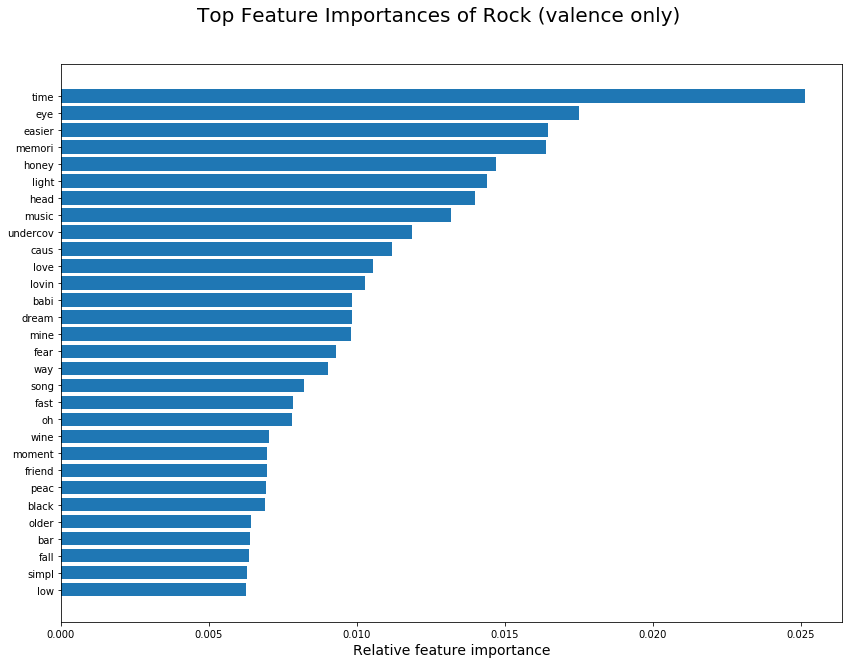

In [33]:
# Plot feature importances
fig, ax = plt.subplots(figsize=(12, 8))
filteredWords = np.array(filter_profanity(lyricsAndValenceRock.columns.difference(['valence'])))
plots.make_feature_importance_plot(feature_importances, filteredWords, 30, ax)
fig.suptitle("Top Feature Importances of Rock (valence only)", fontsize=20)
fig.subplots_adjust(top=0.9)
fig.savefig("images/featureImportances_valencerock.png")

In [34]:
# Multilayer perceptron
score = model.get_mlp_score(10, X_train, X_test, y_train, y_test)
print(score)
# 0.2082

Train on 6884 samples, validate on 1722 samples
Epoch 1/10
6884/6884 [==============================] - 2s 321us/sample - loss: 0.2041 - mean_squared_error: 0.2041 - val_loss: 0.2082 - val_mean_squared_error: 0.2082
Epoch 2/10
6884/6884 [==============================] - 2s 246us/sample - loss: 0.2041 - mean_squared_error: 0.2041 - val_loss: 0.2082 - val_mean_squared_error: 0.2082
Epoch 3/10
6884/6884 [==============================] - 2s 244us/sample - loss: 0.2041 - mean_squared_error: 0.2041 - val_loss: 0.2082 - val_mean_squared_error: 0.2082
Epoch 4/10
6884/6884 [==============================] - 2s 246us/sample - loss: 0.2041 - mean_squared_error: 0.2041 - val_loss: 0.2082 - val_mean_squared_error: 0.2082
Epoch 5/10
6884/6884 [==============================] - 2s 250us/sample - loss: 0.2041 - mean_squared_error: 0.2041 - val_loss: 0.2082 - val_mean_squared_error: 0.2082
Epoch 6/10
6884/6884 [==============================] - 2s 249us/sample - loss: 0.2041 - mean_squared_error: 0.2

In [1]:
try:
    del lyricsAndValence, lyricsAndValencePop, lyricsAndValenceRock, 
    lyricsAndValenceBinPop, lyricsAndValenceBinRock
except:
    pass

In [36]:
###################

In [37]:
# Now try adding all other numerical features to see if it improves accuracy/RMSE

In [38]:
# Join with features to get all numerical features as well as valence
lyricsAndFeatures = tfidfLyrics.merge(features, on='SongID')
lyricsAndFeatures.drop(["Performer", "Song"], axis=1, inplace=True)
lyricsAndFeatures.set_index("SongID", inplace=True)
# Create new dataframe using classifier instead of regressor
lyricsAndFeaturesBin = lyricsAndFeatures.copy()
lyricsAndFeaturesBin['valence'] = (lyricsAndFeaturesBin['valence'] > 0.5).astype(int)

In [39]:
# Run classifier models for pop genre
lyricsAndFeaturesBinPop = lyricsAndFeaturesBin[[contains_genre_type(g, ["pop"]) \
                                for g in lyricsAndFeaturesBin['spotify_genre']]]
lyricsAndFeaturesBinPop.drop(["spotify_genre"], axis=1, inplace=True)
X = lyricsAndFeaturesBinPop[lyricsAndFeaturesBinPop.columns.difference(['valence'])]
y = lyricsAndFeaturesBinPop['valence']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [40]:
# Logistic regression model
logistic_regression_results = model.get_logistic_regression_results(X_train, \
                                        X_test, y_train, y_test)
print(logistic_regression_results)
# 0.6796, 0.5280, 0.5646

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.67964765878535, 0.5279898218829516, 0.564625850340136)


In [41]:
# Explore gradient boosting classifier hyperparameters
'''start = time.time()
model.plot_gradient_boost_class_hyperparameters(X_train, X_test, y_train, y_test, "pop")
end = time.time()
print(end-start)'''

'start = time.time()\nmodel.plot_gradient_boost_class_hyperparameters(X_train, X_test, y_train, y_test, "pop")\nend = time.time()\nprint(end-start)'

In [42]:
# Gradient boosting classifier model
gradient_boost_class_results = model.get_gradient_boost_class_results(0.1, 140, 3, \
                                        X_train, X_test, y_train, y_test)
print(gradient_boost_class_results)
# 0.7821, 0.5954, 0.7548

(0.7719054242002782, 0.5801526717557252, 0.7378640776699029)


In [43]:
# Run regressor models for pop genre
lyricsAndFeaturesPop = lyricsAndFeatures[[contains_genre_type(g, ["pop"]) \
                            for g in lyricsAndFeatures['spotify_genre']]]
lyricsAndFeaturesPop.drop(["spotify_genre"], axis=1, inplace=True)
X = lyricsAndFeaturesPop[lyricsAndFeaturesPop.columns.difference(['valence'])]
y = lyricsAndFeaturesPop['valence']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [44]:
# Baseline RMSE is the standard deviation
print(lyricsAndFeaturesPop['valence'].std())
# 0.2379

0.2379151415411867


In [45]:
'''# Grid search gradient boosting regressor hyperparameters and return model score and RMSE
gbr = model.grid_search_gradient_boost(X_train, X_test, y_train, y_test)
print(gbr.best_params_, np.sqrt(np.abs(gbr.best_score_)))
scoreFeaturesPop = gbr.score(X_test, y_test)
y_pred = gbr.predict(X_test)
rmseFeaturesPop = np.sqrt(mean_squared_error(y_test, y_pred))
print(scoreFeaturesPop, rmseFeaturesPop)'''

'# Grid search gradient boosting regressor hyperparameters and return model score and RMSE\ngbr = model.grid_search_gradient_boost(X_train, X_test, y_train, y_test)\nprint(gbr.best_params_, np.sqrt(np.abs(gbr.best_score_)))\nscoreFeaturesPop = gbr.score(X_test, y_test)\ny_pred = gbr.predict(X_test)\nrmseFeaturesPop = np.sqrt(mean_squared_error(y_test, y_pred))\nprint(scoreFeaturesPop, rmseFeaturesPop)'

In [46]:
# Explore gradient boosting regressor hyperparameters
'''start = time.time()
model.plot_gradient_boost_reg_hyperparameters(X_train, X_test, y_train, y_test, "pop")
end = time.time()
print(end-start)'''

'start = time.time()\nmodel.plot_gradient_boost_reg_hyperparameters(X_train, X_test, y_train, y_test, "pop")\nend = time.time()\nprint(end-start)'

In [47]:
# Gradient boosting regressor model
gradient_boost_reg_results, feature_importances = model.get_gradient_boost_reg_results( \
                            0.05, 120, 3, X_train, X_test, y_train, y_test)
print(gradient_boost_reg_results)
# 0.4659, 0.1711

(0.46111470208047045, 0.1718972484991625)


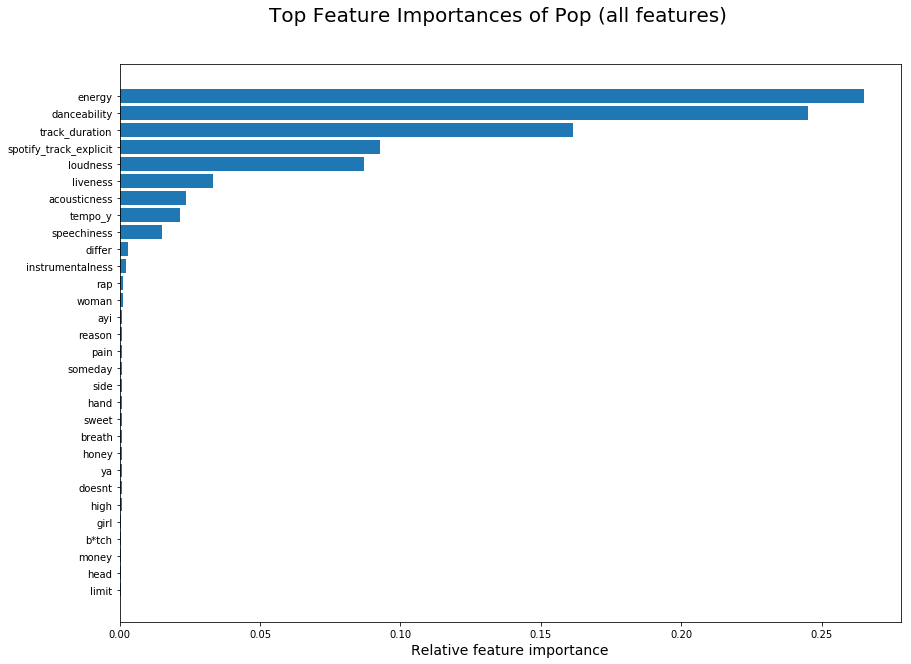

In [48]:
# Plot feature importances
fig, ax = plt.subplots(figsize=(12, 8))
filteredWords = np.array(filter_profanity(lyricsAndFeaturesPop.columns.difference(['valence'])))
plots.make_feature_importance_plot(feature_importances, filteredWords, 30, ax)
fig.suptitle("Top Feature Importances of Pop (all features)", fontsize=20)
fig.subplots_adjust(top=0.9)
fig.savefig("images/featureImportances_featurespop.png")

In [49]:
# Multilayer perceptron
score = model.get_mlp_score(10, X_train, X_test, y_train, y_test)
print(score)
# 0.2244

Train on 8627 samples, validate on 2157 samples
Epoch 1/10
8627/8627 [==============================] - 3s 315us/sample - loss: 0.2263 - mean_squared_error: 0.2263 - val_loss: 0.2245 - val_mean_squared_error: 0.2245
Epoch 2/10
8627/8627 [==============================] - 2s 258us/sample - loss: 0.2263 - mean_squared_error: 0.2263 - val_loss: 0.2245 - val_mean_squared_error: 0.2245
Epoch 3/10
8627/8627 [==============================] - 2s 256us/sample - loss: 0.2263 - mean_squared_error: 0.2263 - val_loss: 0.2245 - val_mean_squared_error: 0.2245
Epoch 4/10
8627/8627 [==============================] - 2s 259us/sample - loss: 0.2263 - mean_squared_error: 0.2263 - val_loss: 0.2245 - val_mean_squared_error: 0.2245
Epoch 5/10
8627/8627 [==============================] - 2s 252us/sample - loss: 0.2263 - mean_squared_error: 0.2263 - val_loss: 0.2245 - val_mean_squared_error: 0.2245
Epoch 6/10
8627/8627 [==============================] - 2s 252us/sample - loss: 0.2263 - mean_squared_error: 0.2

In [50]:
# Run classifier models for rock/metal genres
lyricsAndFeaturesBinRock = lyricsAndFeaturesBin[[contains_genre_type(g, ["rock", "metal"]) \
                                for g in lyricsAndFeaturesBin['spotify_genre']]]
lyricsAndFeaturesBinRock.drop(["spotify_genre"], axis=1, inplace=True)
X = lyricsAndFeaturesBinRock[lyricsAndFeaturesBinRock.columns.difference(['valence'])]
y = lyricsAndFeaturesBinRock['valence']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [51]:
# Logistic regression model
logistic_regression_results = model.get_logistic_regression_results(X_train, \
                                        X_test, y_train, y_test)
print(logistic_regression_results)
# 0.7294, 0.6028, 0.5925

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.7293844367015099, 0.6027874564459931, 0.5924657534246576)


In [52]:
# Explore gradient boosting classifier hyperparameters
'''start = time.time()
model.plot_gradient_boost_class_hyperparameters(X_train, X_test, y_train, y_test, "rock")
end = time.time()
print(end-start)'''

'start = time.time()\nmodel.plot_gradient_boost_class_hyperparameters(X_train, X_test, y_train, y_test, "rock")\nend = time.time()\nprint(end-start)'

In [53]:
# Gradient boosting classifier model
gradient_boost_class_results = model.get_gradient_boost_class_results(0.1, 140, 3, \
                                        X_train, X_test, y_train, y_test)
print(gradient_boost_class_results)
# 0.8055, 0.6045, 0.7626

(0.8037166085946573, 0.6219512195121951, 0.7468619246861925)


In [54]:
# Run regressor models for rock/metal genres
lyricsAndFeaturesRock = lyricsAndFeatures[[contains_genre_type(g, ["rock", "metal"]) \
                            for g in lyricsAndFeatures['spotify_genre']]]
lyricsAndFeaturesRock.drop(["spotify_genre"], axis=1, inplace=True)
X = lyricsAndFeaturesRock[lyricsAndFeaturesRock.columns.difference(['valence'])]
y = lyricsAndFeaturesRock['valence']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [55]:
# Baseline RMSE is the standard deviation
print(lyricsAndFeaturesRock['valence'].std())
# 0.2362

0.23619660739337392


In [56]:
'''# Grid search gradient boosting regressor hyperparameters and return model score and RMSE
gbr = model.grid_search_gradient_boost(X_train, X_test, y_train, y_test)
print(gbr.best_params_, np.sqrt(np.abs(gbr.best_score_)))
scoreFeaturesRock = gbr.score(X_test, y_test)
y_pred = gbr.predict(X_test)
rmseFeaturesRock = np.sqrt(mean_squared_error(y_test, y_pred))
print(scoreFeaturesRock, rmseFeaturesRock)'''

'# Grid search gradient boosting regressor hyperparameters and return model score and RMSE\ngbr = model.grid_search_gradient_boost(X_train, X_test, y_train, y_test)\nprint(gbr.best_params_, np.sqrt(np.abs(gbr.best_score_)))\nscoreFeaturesRock = gbr.score(X_test, y_test)\ny_pred = gbr.predict(X_test)\nrmseFeaturesRock = np.sqrt(mean_squared_error(y_test, y_pred))\nprint(scoreFeaturesRock, rmseFeaturesRock)'

In [57]:
# Explore gradient boosting regressor hyperparameters
'''start = time.time()
model.plot_gradient_boost_reg_hyperparameters(X_train, X_test, y_train, y_test, "rock")
end = time.time()
print(end-start)'''

'start = time.time()\nmodel.plot_gradient_boost_reg_hyperparameters(X_train, X_test, y_train, y_test, "rock")\nend = time.time()\nprint(end-start)'

In [58]:
# Gradient boosting regressor model
gradient_boost_reg_results, feature_importances = model.get_gradient_boost_reg_results( \
                            0.05, 120, 3, X_train, X_test, y_train, y_test)
print(gradient_boost_reg_results)
# 0.5324, 0.1610

(0.5346803190241006, 0.16059482368039335)


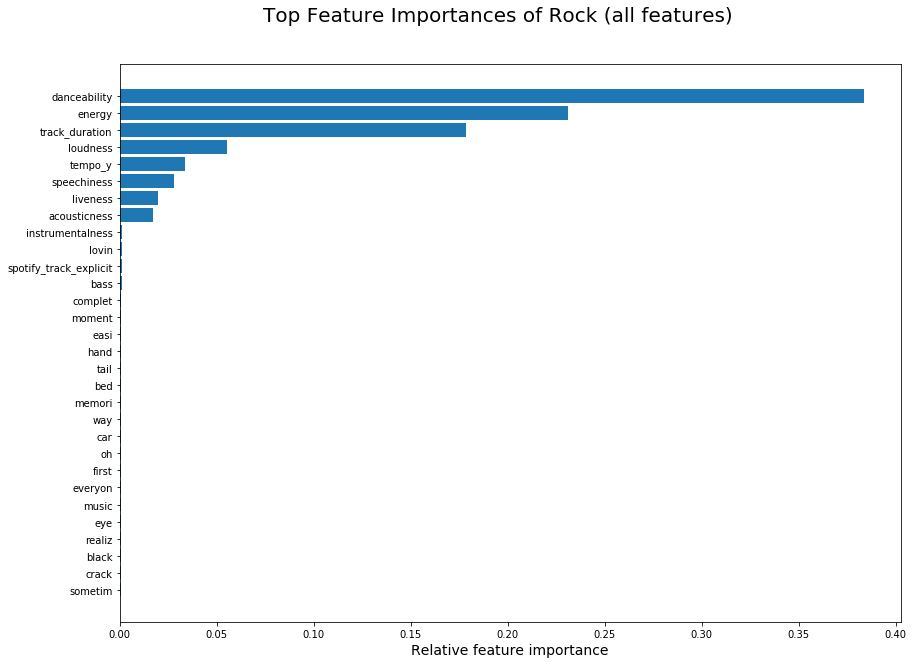

In [59]:
# Plot feature importances
fig, ax = plt.subplots(figsize=(12, 8))
filteredWords = np.array(filter_profanity(lyricsAndFeaturesRock.columns.difference(['valence'])))
plots.make_feature_importance_plot(feature_importances, filteredWords, 30, ax)
fig.suptitle("Top Feature Importances of Rock (all features)", fontsize=20)
fig.subplots_adjust(top=0.9)
fig.savefig("images/featureImportances_featuresrock.png")

In [60]:
# Multilayer perceptron
score = model.get_mlp_score(10, X_train, X_test, y_train, y_test)
print(score)
# 0.2082

Train on 6884 samples, validate on 1722 samples
Epoch 1/10
6884/6884 [==============================] - 2s 327us/sample - loss: 0.2041 - mean_squared_error: 0.2041 - val_loss: 0.2082 - val_mean_squared_error: 0.2082
Epoch 2/10
6884/6884 [==============================] - 2s 256us/sample - loss: 0.2041 - mean_squared_error: 0.2041 - val_loss: 0.2082 - val_mean_squared_error: 0.2082
Epoch 3/10
6884/6884 [==============================] - 2s 252us/sample - loss: 0.2041 - mean_squared_error: 0.2041 - val_loss: 0.2082 - val_mean_squared_error: 0.2082
Epoch 4/10
6884/6884 [==============================] - 2s 253us/sample - loss: 0.2041 - mean_squared_error: 0.2041 - val_loss: 0.2082 - val_mean_squared_error: 0.2082
Epoch 5/10
6884/6884 [==============================] - 2s 251us/sample - loss: 0.2041 - mean_squared_error: 0.2041 - val_loss: 0.2082 - val_mean_squared_error: 0.2082
Epoch 6/10
6884/6884 [==============================] - 2s 252us/sample - loss: 0.2041 - mean_squared_error: 0.2

In [61]:
try:
    del lyricsAndFeatures, lyricsAndFeaturesPop, lyricsAndFeaturesRock,
    lyricsAndFeaturesBinPop, lyricsAndFeaturesBinRock
except:
    pass